In [1]:
import os

import torch
import urllib
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg19


import numpy as np
# import cv2

# # load the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', pretrained=True)
model = model.to(device)

model.eval()

Using cache found in /Users/hiren/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/hiren/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hiren/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [2]:
from torchvision import datasets
from torch.utils import data
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
#                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                               ])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='/Users/hiren/Desktop/imgs/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [3]:
class VGG(torch.nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

/Users/hiren/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hiren/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


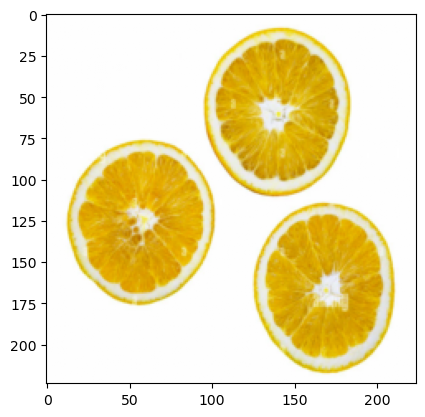

In [4]:
import matplotlib.pyplot as plt
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))
plt.imshow(img.cpu().squeeze().permute(1, 2, 0))

# get the most likely prediction of the model
pred = vgg(img)

In [5]:
print(pred.argmax(dim=1))

tensor([951])


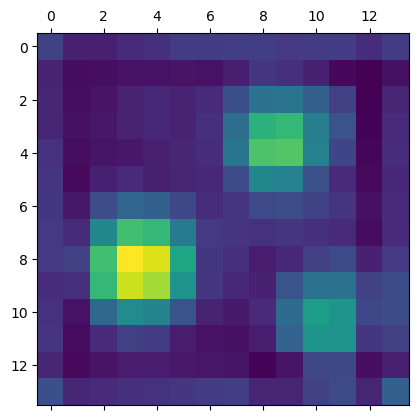

In [6]:
# get the gradient of the output with respect to the parameters of the model
c = pred.argmax(dim=1)
pred[:, c].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [7]:
# import cv2
# img = cv2.imread('/Users/hiren/Desktop/imgs/circle/1.png')
# heatmap = cv2.resize(np.array(heatmap), (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.merge((heatmap,heatmap,heatmap))
# # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# superimposed_img = heatmap * 0.9 + img * 0.95
# cv2.imwrite('./map.jpg', superimposed_img)

(224, 224)
(224, 224)
(224, 224, 3)
(224, 224, 3)


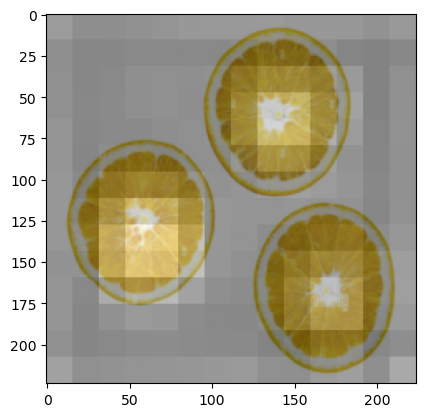

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load the two images

# Create a figure and axes
fig, ax = plt.subplots()

# Display the first image
ax.imshow(img.cpu().squeeze().permute(1, 2, 0))
img_2 = img.cpu().squeeze().permute(1, 2, 0)

heatmap_1=np.kron(np.array(heatmap), np.ones((16,16)))
# heatmap_1 = cv2.resize(np.array(heatmap), (16, 16))
heatmap_2 = np.uint8(255 * heatmap_1)
heatmap_3 = cv2.merge((heatmap_2,heatmap_2,heatmap_2))

print(heatmap_1.shape)
print(heatmap_2.shape)
print(heatmap_3.shape)
print(heatmap_3.squeeze().shape)

# Overlay the second image with transparency
ax.imshow(heatmap_3, alpha=0.5, cmap='gray')

# Save the overlaid image to a PNG file
plt.savefig('sample.png')
